## 1. 데이터 준비

In [1]:
%matplotlib inline
from IPython.display import clear_output
import os
from copy import deepcopy
import pickle

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz
import torch.nn as nn
from sklearn.decomposition import PCA
import random

from helper import ExperimentLogger, display_train_stats
from fl_devices import Server, Client
from data_utils import generate_server_idcs, CustomSubset, split_3class_unbalanced, split_7plus3class_unbalanced
from torchvision.models import mobilenet_v3_large
from models import ConvNet, Representation
import seaborn as sns
from sklearn.metrics import pairwise_distances
from scipy.spatial import distance

torch.manual_seed(42)
np.random.seed(42)

In [2]:
LOCAL_EPOCHS = 25
N_CLIENTS = 100
NUMBER_OF_CLUSTER = 3
ALPHA = 0.1

In [3]:
# data = datasets.CIFAR10(root="CIFAR10/", download=False)
data = datasets.MNIST(root="MNIST/", download=False)
idcs = np.random.permutation(len(data))

def cluster(server, clients, number_of_cluster):
    label_predicted = pd.DataFrame()
    # label_acc = pd.DataFrame()
    for i, client in enumerate(clients):
        pred = server.check_cluster(client.model)
        # print(f'pred: {pred}')
        label_predicted = pd.concat([label_predicted, pd.DataFrame(pred, index=[i])])
        # label_acc = pd.concat([label_acc, pd.DataFrame(acc, index=[i])])
    label_predicted.reset_index(drop=True, inplace=True)
    label_predicted.fillna(0, inplace=True)
    
    print(f'predicted label')
    print(label_predicted)

    cluster_idcs = server.cluster_clients_GMM(label_predicted, number_of_cluster)
    return label_predicted, cluster_idcs



def get_cluster_averages(df, cluster_idcs):
    cluster_averages = {}

    for i, cluster in enumerate(cluster_idcs):
        cluster_data = df.loc[cluster, :]
        cluster_average = cluster_data.mean()
        cluster_averages[i] = cluster_average

    cluster_averages_df = pd.DataFrame(cluster_averages).T

    # calculate percentage for each value in a row
    cluster_percentages_df = cluster_averages_df.div(cluster_averages_df.sum(axis=1), axis=0).multiply(100)

    # apply threshold and rounding
    cluster_percentages_df = cluster_percentages_df.where(cluster_percentages_df >= 5, 0).round()

    return cluster_percentages_df / 10


def get_cluster_weights(cluster_logits, cluster_weight_per_class):
    # Step 1: Find the class with the maximum value in each logit in cluster_logits
    # Assuming the dimension for classes is the second one
    max_classes = [torch.argmax(logit, dim=1) for logit in cluster_logits]
    
    print(max_classes)
    cluster_weights = []
    #c luster별로 
    for i, iogits in enumerate(cluster_logits):
        weights = []
        for j, logit in enumerate(logits):
            
            # print(f'max_classes: {max_classes[i][j]}')
            # print("Shape of cluster_weight_per_class[{}]: ".format(i), cluster_weight_per_class[i].shape)
            weights.append(max_classes[i][j])
        print(weights)
        cluster_weights.append(weights)

def visualize_clusters(label_predicted, clusters, real_cluster_distribution):
    # Reduce the dimension of the data
    pca = PCA(n_components=2)
    label_predicted_pca = pca.fit_transform(label_predicted)

    # Define colors for the clusters
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'yellow', 'black']

    # Plot the clusters
    plt.figure(figsize=(10,7))
    
    for i, cluster in enumerate(clusters):
        plt.scatter(label_predicted_pca[cluster, 0], label_predicted_pca[cluster, 1], c=colors[i % len(colors)], label=f'Cluster {i+1}')

    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the real cluster distribution
    print("Real cluster distribution:", real_cluster_distribution)

    # Calculate and print each client's cluster identity based on the real_cluster_distribution
    n_clients = len(label_predicted)
    cumulative_distribution = [0] + [sum(real_cluster_distribution[:i+1]) for i in range(len(real_cluster_distribution))]
    client_cluster_id_real = [next((i for i, val in enumerate(cumulative_distribution) if val > client_idx / n_clients), -1) - 1 for client_idx in range(n_clients)]

    print("Real cluster identity for each client:", client_cluster_id_real)

    # Print each client's cluster identity based on the clusters argument
    client_cluster_id_predicted = [next((i for i, cluster in enumerate(clusters) if client_idx in cluster), -1) for client_idx in range(n_clients)]
    print("Predicted cluster identity for each client:", client_cluster_id_predicted)




def test_acc(server, clients, client_accs, cluster_accs, global_accs, client_distribution=[0.5, 0.3, 0.2]):
    
    # Get individual client accuracies
    acc_clients = [client.evaluate() for client in clients]

    # Compute the average accuracy for each client
    client_acc = round(sum(acc_clients) / len(acc_clients), 3) if len(acc_clients) > 0 else 0
    client_accs.append(client_acc)

    # Compute cluster accuracies for this iteration
    cluster_accs_iteration = []
    start_idx = 0
    for distribution in client_distribution:
        end_idx = start_idx + int(distribution * len(clients))
        cluster_acc = round(sum(acc_clients[start_idx:end_idx]) / (end_idx - start_idx), 3)
        cluster_accs_iteration.append(cluster_acc)
        start_idx = end_idx
    cluster_accs.append(cluster_accs_iteration)
    
    accuracies = [server.evaluate_distil(client.model) for client in clients]
    global_acc = round(np.mean(accuracies), 3)
    global_accs.append(global_acc)
    
    return client_accs, cluster_accs, global_accs


def get_global_logits(client_logits):
    avg_logits = torch.mean(torch.stack(client_logits), dim=0)
    return avg_logits

def get_cluster_logits(client_logits, cluster_idcs):
    cluster_logits = []
    for i, cluster in enumerate(cluster_idcs):
        cluster_client_logits = [client_logits[i] for i in cluster]
        avg_cluster_logits = torch.mean(torch.stack(cluster_client_logits), dim=0)
        cluster_logits.append(avg_cluster_logits)
    return cluster_logits


def get_cluster_averages(df, cluster_idcs):
    cluster_averages = {}

    for i, cluster in enumerate(cluster_idcs):
        cluster_data = df.loc[cluster, :]
        cluster_average = cluster_data.mean()
        cluster_averages[i] = cluster_average

    cluster_averages_df = pd.DataFrame(cluster_averages).T

    # calculate percentage for each value in a row
    cluster_percentages_df = cluster_averages_df.div(cluster_averages_df.sum(axis=1), axis=0).multiply(100)

    # apply threshold and rounding
    cluster_percentages_df = cluster_percentages_df.where(cluster_percentages_df >= 5, 0).round()

    return cluster_percentages_df / 10


# def get_cluster_weights(cluster_logits, cluster_weight_per_class):
#     # Step 1: Find the class with the maximum value in each logit in cluster_logits
#     # Assuming the dimension for classes is the second one
#     max_classes = [torch.argmax(logit, dim=1) for logit in cluster_logits]
    
#     print(max_classes)
#     cluster_weights = []
#     #c luster별로 
#     for i, iogits in enumerate(cluster_logits):
#         weights = []
#         for j, logit in enumerate(logits):
            
#             # print(f'max_classes: {max_classes[i][j]}')
#             # print("Shape of cluster_weight_per_class[{}]: ".format(i), cluster_weight_per_class[i].shape)
#             weights.append(max_classes[i][j])
#         print(weights)
#         cluster_weights.append(weights)


In [ ]:
def SimCLR_distill_experiments(total_client_data, distill_data, alpha, number_of_cluster, cluster_distribution):
    print(f'number_of_cluster: {number_of_cluster}')
    data_per_class=int(distill_data//10)
    train_idcs, test_idcs = idcs[:total_client_data], idcs[total_client_data:(total_client_data + int(distill_data * 2))]
    train_labels = data.targets
    test_labels = data.targets
    
    server_idcs = generate_server_idcs(test_idcs, test_labels, int(distill_data//10))

    # client_idcs = split_noniid(train_idcs, train_labels, alpha=alpha, n_clients=N_CLIENTS)
    client_idcs = split_7plus3class_unbalanced(train_idcs, train_labels, N_CLIENTS, cluster_distribution)
    
    print('client idcs generated!')
    client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
    test_data = CustomSubset(data, server_idcs, transforms.Compose([transforms.ToTensor()]))

    for i, client_datum in enumerate(client_data):
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

    server = Server(ConvNet, lambda x : torch.optim.Adam(x, weight_decay=0.1),test_data)

    clients = [Client(ConvNet, lambda x: torch.optim.Adam(x, weight_decay=0.1), dat, i) 
           for i, dat in enumerate(client_data) if len(dat) > 20]
    
    print(f'client count: {len(clients)}')

    client_accs = []
    cluster_accs = []
    global_accs = []
    client_logits = []
    
    # 1. Pre-Train Representaion with SimCLR
    for epoch in range(LOCAL_EPOCHS):
        for i, client in enumerate(clients):
            client.learn_representation()
    # 2. Train Local Major Class Classifier
    for epoch in range(LOCAL_EPOCHS):
        for i, client in enumerate(clients):
            client.compute_weight_update(epochs=1)

        if epoch % 5 == 0:
            client_accs, cluster_accs, global_accs = test_acc(server, clients, client_accs, cluster_accs, global_accs, cluster_distribution)
            print(f'client_acc: {client_accs[-1]}, cluster_acc: {cluster_distribution}: {cluster_accs[-1]},  global_acc: {global_accs[-1]}')
    
    # 3. Train In and Out- Class Classifier 
    # 2. get global loigt
    for i, client in enumerate(clients):
        if i == 0:
            distill_data = server.get_clients_logit(client.model)
            client_logits.append(distill_data[2])
        else:
            client_logits.append(server.get_clients_logit(client.model)[2])
    global_logits = get_global_logits(client_logits)
    
    # 3.Distillation
    for i, client in enumerate(clients):
        if i % 10 == 0:
            print(f'client {i} distill')
        
        client.distill((distill_data[0], global_logits))
    
    client_accs, cluster_accs, global_accs = test_acc(server, clients, client_accs, cluster_accs, global_accs, cluster_distribution)
    
    print(f'total_client_data: {total_client_data}, cluster_distribution: {cluster_distribution}')
    print(f'first acc: {client_accs[0]}, {cluster_accs[0]}, {global_accs[0]}')
    print(f'acc before distill: {client_accs[-2]}, {cluster_accs[-2]}, {global_accs[-2]}')
    print(f'last acc: {client_accs[-1]}, {cluster_accs[-1]}, {global_accs[-1]}')
    return client_accs, cluster_accs, global_accs

In [4]:
def global_distill_experiments(total_client_data, distill_data, alpha, number_of_cluster, cluster_distribution):
    print(f'number_of_cluster: {number_of_cluster}')
    data_per_class=int(distill_data//10)
    train_idcs, test_idcs = idcs[:total_client_data], idcs[total_client_data:(total_client_data + int(distill_data * 2))]
    train_labels = data.targets
    test_labels = data.targets
    
    server_idcs = generate_server_idcs(test_idcs, test_labels, int(distill_data//10))

    # client_idcs = split_noniid(train_idcs, train_labels, alpha=alpha, n_clients=N_CLIENTS)
    client_idcs = split_7plus3class_unbalanced(train_idcs, train_labels, N_CLIENTS, cluster_distribution)
    
    print('client idcs generated!')
    client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
    test_data = CustomSubset(data, server_idcs, transforms.Compose([transforms.ToTensor()]))

    for i, client_datum in enumerate(client_data):
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

    server = Server(ConvNet, lambda x : torch.optim.Adam(x, weight_decay=0.1),test_data)

    clients = [Client(ConvNet, lambda x: torch.optim.Adam(x, weight_decay=0.1), dat, i) 
           for i, dat in enumerate(client_data) if len(dat) > 20]
    
    print(f'client count: {len(clients)}')

    client_accs = []
    cluster_accs = []
    global_accs = []
    client_logits = []
    
    # 1.Local training
    for epoch in range(LOCAL_EPOCHS):
        for i, client in enumerate(clients):
            client.compute_weight_update(epochs=1)

        if epoch % 5 == 0:
            client_accs, cluster_accs, global_accs = test_acc(server, clients, client_accs, cluster_accs, global_accs, cluster_distribution)
            print(f'client_acc: {client_accs[-1]}, cluster_acc: {cluster_distribution}: {cluster_accs[-1]},  global_acc: {global_accs[-1]}')
      
    # 2. get global loigt
    for i, client in enumerate(clients):
        if i == 0:
            distill_data = server.get_clients_logit(client.model)
            client_logits.append(distill_data[2])
        else:
            client_logits.append(server.get_clients_logit(client.model)[2])
    global_logits = get_global_logits(client_logits)
    
    # 3.Distillation
    for i, client in enumerate(clients):
        if i % 10 == 0:
            print(f'client {i} distill')
        
        client.distill((distill_data[0], global_logits))
    
    client_accs, cluster_accs, global_accs = test_acc(server, clients, client_accs, cluster_accs, global_accs, cluster_distribution)
    
    print(f'total_client_data: {total_client_data}, cluster_distribution: {cluster_distribution}')
    print(f'first acc: {client_accs[0]}, {cluster_accs[0]}, {global_accs[0]}')
    print(f'acc before distill: {client_accs[-2]}, {cluster_accs[-2]}, {global_accs[-2]}')
    print(f'last acc: {client_accs[-1]}, {cluster_accs[-1]}, {global_accs[-1]}')
    return client_accs, cluster_accs, global_accs

In [5]:
def cluster_distill_experiments(total_client_data, distill_data, alpha, number_of_cluster, cluster_distribution):
    print(f'number_of_cluster: {number_of_cluster}')
    data_per_class=int(distill_data//10)
    train_idcs, test_idcs = idcs[:total_client_data], idcs[total_client_data:(total_client_data + int(distill_data * 2))]
    train_labels = data.targets
    test_labels = data.targets
    
    server_idcs = generate_server_idcs(test_idcs, test_labels, int(distill_data//10))

    #client_idcs = split_noniid(train_idcs, train_labels, alpha=alpha, n_clients=N_CLIENTS)
    client_idcs = split_7plus3class_unbalanced(train_idcs, train_labels, N_CLIENTS, cluster_distribution)
    
    print('client idcs generated!')
    client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
    print(f'server data length: {len(server_idcs)}')
    test_data = CustomSubset(data, server_idcs, transforms.Compose([transforms.ToTensor()]))

    for i, client_datum in enumerate(client_data):
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

    server = Server(ConvNet, lambda x : torch.optim.Adam(x, weight_decay=0.1),test_data)

    clients = [Client(ConvNet, lambda x: torch.optim.Adam(x, weight_decay=0.1), dat, i) 
           for i, dat in enumerate(client_data) if len(dat) > 20]
    
    print(f'client count: {len(clients)}')

    client_accs = []
    cluster_accs = []
    global_accs = []
    client_logits = []
    
    # 1.Local training
    for epoch in range(1, LOCAL_EPOCHS + 1):
        for i, client in enumerate(clients):
            client.compute_weight_update(epochs=1)

        if epoch % 5 == 0:
            client_accs, cluster_accs, global_accs = test_acc(server, clients, client_accs, cluster_accs, global_accs, cluster_distribution)
            print(f'client_acc: {client_accs[-1]}, cluster_acc: {cluster_distribution}: {cluster_accs[-1]},  global_acc: {global_accs[-1]}')

    # 2.Clustering
    label_predicted, cluster_idcs = cluster(server, clients, number_of_cluster)
    cluster_weight_per_class = get_cluster_averages(label_predicted.sort_index(axis=1), cluster_idcs)
    # print(cluster_weight_per_class)
    visualize_clusters(label_predicted, cluster_idcs, cluster_distribution)
        
    # 3.Get cluster, global loigt
    for i, client in enumerate(clients):
        if i == 0:
            distill_data = server.get_clients_logit(client.model)
            client_logits.append(distill_data[2])
        else:
            client_logits.append(server.get_clients_logit(client.model)[2])
    global_logits = get_global_logits(client_logits)
    
    cluster_logits = get_cluster_logits(client_logits, cluster_idcs)
    # cluster_weights = get_cluster_weights(cluster_logits, cluster_weight_per_class)
    
    # 4.Distillation
    for i, client in enumerate(clients):
        if i % 10 == 0:
            print(f'client {i} distill')
        
             # Find the corresponding cluster for the client
        cluster_idx = next(j for j, cluster in enumerate(cluster_idcs) if i in cluster)

        # Extract the corresponding cluster logits
        my_cluster_logit = cluster_logits[cluster_idx]
        
        client.distill((distill_data[0], my_cluster_logit))
    
    client_accs, cluster_accs, global_accs = test_acc(server, clients, client_accs, cluster_accs, global_accs, cluster_distribution)
    
    print(f'total_client_data: {total_client_data}, cluster_distribution: {cluster_distribution}')
    print(f'first acc: {client_accs[0]}, {cluster_accs[0]}, {global_accs[0]}')
    print(f'acc before distill: {client_accs[-2]}, {cluster_accs[-2]}, {global_accs[-2]}')
    print(f'last acc: {client_accs[-1]}, {cluster_accs[-1]}, {global_accs[-1]}')
    return client_accs, cluster_accs, global_accs

number_of_cluster: 3
client idcs generated!
server data length: 5000
Train Label Distribution for client 0: Counter({0: 35, 1: 35, 2: 35, 3: 7, 4: 7, 8: 7, 9: 7, 6: 7, 5: 7, 7: 7})
Evaluation Label Distribution for client 0: Counter({2: 15, 1: 15, 0: 15, 9: 3, 6: 3, 4: 3, 8: 3, 3: 3, 5: 3, 7: 3})
Train Label Distribution for client 10: Counter({0: 35, 1: 35, 2: 35, 5: 7, 9: 7, 6: 7, 4: 7, 8: 7, 3: 7, 7: 7})
Evaluation Label Distribution for client 10: Counter({2: 15, 1: 15, 0: 15, 8: 3, 5: 3, 4: 3, 6: 3, 3: 3, 9: 3, 7: 3})
Train Label Distribution for client 20: Counter({2: 35, 0: 35, 1: 35, 8: 7, 4: 7, 3: 7, 7: 7, 5: 7, 9: 7, 6: 7})
Evaluation Label Distribution for client 20: Counter({0: 15, 1: 15, 2: 15, 8: 3, 3: 3, 7: 3, 6: 3, 9: 3, 4: 3, 5: 3})
Train Label Distribution for client 30: Counter({1: 35, 2: 35, 0: 35, 9: 7, 8: 7, 6: 7, 4: 7, 3: 7, 7: 7, 5: 7})
Evaluation Label Distribution for client 30: Counter({2: 15, 1: 15, 0: 15, 5: 3, 7: 3, 9: 3, 3: 3, 8: 3, 6: 3, 4: 3})
Train Lab

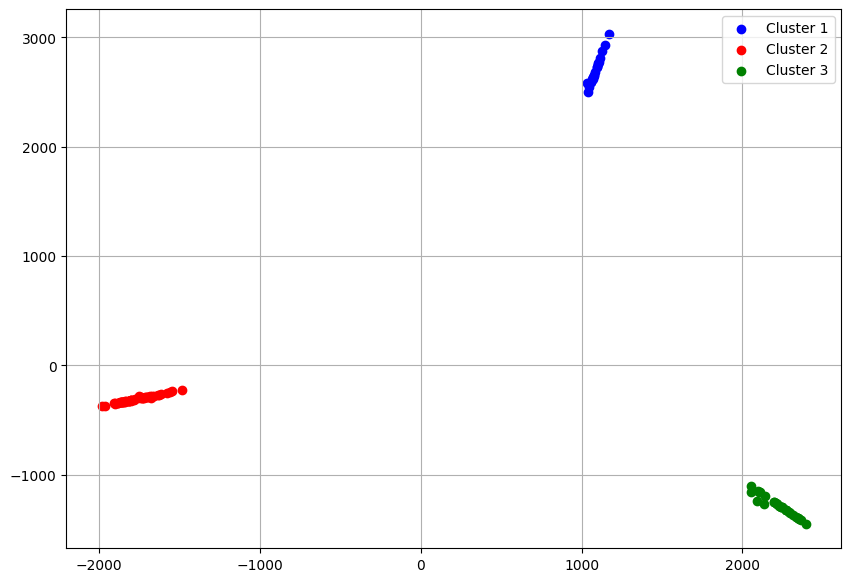

Real cluster distribution: [0.5, 0.3, 0.2]
Real cluster identity for each client: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Predicted cluster identity for each client: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
client 0 distill
distill epoch 5, averaged loss: 0.0065
distill epoch 10, averaged loss: 0.0051
distill epoch 15, averaged loss: 0.0051
distill epoch 20, averaged loss: 0.0048
client 10 distill
client 20 distill
client 30 distill
client 40 distill
client 50 distill
distil

In [6]:
now = datetime.datetime.now(pytz.timezone('Asia/Seoul'))
date_time = now.strftime("%m%d_%H%M")

columns = pd.MultiIndex.from_product([['client_accs', 'cluster_accs', 'global_accs'], ['before_distill', 'after_distill']],
                                     names=['acc_type', 'distill_state'])

# The tuples for which we want to run the experiment 
desired_pairs = [(50000, 5000)]
cluster_distribution = [0.5, 0.3, 0.2]
# Add additional index 'global_distill' and 'cluster_distill'
experiments = ['cluster_distill', 'global_distill']
index = pd.MultiIndex.from_product([experiments, desired_pairs], names=['experiment', 'data_pair'])

# Initialize an empty DataFrame with the desired index for rows and columns
df = pd.DataFrame(index=index, columns=columns)

for exp in experiments:
    for pair in desired_pairs:
        client_data, distill_data = pair

        if exp == 'global_distill':
            client_accs, cluster_accs, global_accs = global_distill_experiments(client_data, distill_data, ALPHA, NUMBER_OF_CLUSTER, cluster_distribution)
        else:
            client_accs, cluster_accs, global_accs = cluster_distill_experiments(client_data, distill_data, ALPHA, NUMBER_OF_CLUSTER, cluster_distribution)

        # Set the values in the DataFrame
        df.loc[(exp, pair), ('client_accs', 'before_distill')] = client_accs[-2]
        df.loc[(exp, pair), ('client_accs', 'after_distill')] = client_accs[-1]
        df.loc[(exp, pair), ('global_accs', 'before_distill')] = global_accs[-2]
        df.loc[(exp, pair), ('global_accs', 'after_distill')] = global_accs[-1]
        df.loc[(exp, pair), ('cluster_accs', 'before_distill')] = cluster_accs[-2]
        df.loc[(exp, pair), ('cluster_accs', 'after_distill')] = cluster_accs[-1]

        directory = f'results/Unbalanced_cluster'

        if not os.path.exists(directory):
            os.makedirs(directory)
        cluster_distribution_str = "_".join(map(str, cluster_distribution))
        file_name = f'{directory}/client:{N_CLIENTS}_cluster:{NUMBER_OF_CLUSTER}_distribution:{cluster_distribution_str}_{date_time}.csv'
        df = df.round(decimals=3)
        df.to_csv(file_name)

In [7]:
df

acc_type                         client_accs                \
distill_state                 before_distill after_distill   
experiment      data_pair                                    
cluster_distill (50000, 5000)          0.615         0.627   
global_distill  (50000, 5000)          0.595         0.435   

acc_type                                cluster_accs                         \
distill_state                         before_distill          after_distill   
experiment      data_pair                                                     
cluster_distill (50000, 5000)   [0.64, 0.573, 0.617]   [0.65, 0.582, 0.637]   
global_distill  (50000, 5000)  [0.627, 0.525, 0.619]  [0.668, 0.225, 0.166]   

acc_type                         global_accs                
distill_state                 before_distill after_distill  
experiment      data_pair                                   
cluster_distill (50000, 5000)          0.479         0.485  
global_distill  (50000, 5000)          0.473         0.969

In [8]:
df = pd.read_csv('results/global_distill/CIFAR_0720_0435.csv', index_col=[0,1], header=[0,1])

# 그릴 데이터와 제목을 리스트로 저장
heatmap_data = [('client_accs', 'change_after_distill', 'Client Accuracy change after Distillation'),
                ('global_accs', 'change_after_distill', 'Global Accuracy change after Distillation')]

# Compute change in accuracy
df[('client_accs', 'change_after_distill')] = df[('client_accs', 'after_distill')] - df[('client_accs', 'before_distill')]
df[('global_accs', 'change_after_distill')] = df[('global_accs', 'after_distill')] - df[('global_accs', 'before_distill')]

# 전체 데이터의 최솟값, 최댓값 계산
vmin = min(df[data1][data2].min() for data1, data2, _ in heatmap_data)
vmax = max(df[data1][data2].max() for data1, data2, _ in heatmap_data)

for data1, data2, title in heatmap_data:
    plt.figure(figsize=(9, 5))
    sns.heatmap(df[(data1, data2)].unstack(), annot=True, cmap='coolwarm', center=0, vmin=-0.1, vmax=0.2)
    plt.title(title)
    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'results/global_distill/CIFAR_0720_0435.csv'

## 2.Clustering 실험

In [ ]:
def do_clustering_experiments(total_client_data=total_client_data, data_per_class=data_per_class, ALPHA=ALPHA):
    train_idcs, test_idcs = idcs[:int(total_client_data*10)], idcs[int(total_client_data*10):]
    train_labels = data.train_labels.numpy()
    test_labels = data.train_labels.numpy()[int(total_client_data*10):]

    client_idcs = split_noniid(train_idcs, train_labels, alpha=ALPHA, n_clients=N_CLIENTS)#, data_per_class=int(total_client_data/10))
    # server_idcs = generate_server_idcs(test_idcs, test_labels, int(total_client_data*10))

    client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
    test_data = CustomSubset(data, test_idcs, transforms.Compose([transforms.ToTensor()]))
    
    for i, client_datum in enumerate(client_data):
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

    server = Server(resnet18, lambda x : torch.optim.SGD(x, lr=0.1, momentum=0.9),test_data)

    
    distillation_data_file = f'distillation_data_{data_per_class}_per_class.pth'

    # Check if the file already exists
    if not os.path.exists(distillation_data_file):
        # The file does not exist, generate and save the distillation data
        distillation_data = server.make_distillation_data(data_per_class=data_per_class)
        torch.save(distillation_data, distillation_data_file)

    # Load the distillation data
    distillation_data = torch.load(distillation_data_file)

    clients = [Client(resnet18, lambda x : torch.optim.SGD(x, lr=0.1, momentum=0.9), dat, i, distillation_data) 
               for i, dat in enumerate(client_data)]

    def aggregate(cluster_indices_new):
        cluster_indices = cluster_indices_new
        client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]

        server.aggregate_clusterwise(client_clusters)

        return cluster_indices

    cfl_stats = ExperimentLogger()

    cluster_indices = [np.arange(len(clients)).astype("int")]
    client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]


    for epoch in range(1, LOCAL_EPOCHS+1):

        if epoch == 1:
            for client in clients:
                client.synchronize_with_server(server)

        participating_clients = server.select_clients(clients, frac=1.0)

        for client in participating_clients:
            if epoch == 1:
                client.distill()

            train_stats = client.compute_weight_update(epochs=1) #train client

            if epoch == 1000:
                client.reset()

        cluster_indices_new = []

        for idc in cluster_indices:
            max_norm = server.compute_max_update_norm([clients[i] for i in idc])
            mean_norm = server.compute_mean_update_norm([clients[i] for i in idc])

            #cluster 나누는 기준
            if epoch == LOCAL_EPOCHS: #무조건 한번 나누기
                similarities = server.compute_pairwise_similarities(clients)

                server.cache_model(idc, clients[idc[0]].W, acc_clients)

                c1, c2, c3 = server.cluster_clients_GMM(similarities[idc][:,idc])
                cluster_indices_new += [c1, c2, c3]

        if epoch == 1000:
            cluster_indices = aggregate(cluster_indices_new)

        acc_clients = [client.evaluate() for client in clients]

        if epoch == LOCAL_EPOCHS: #무조건 한번 나누기
            label_accuracies = pd.DataFrame()
            label_predicted = pd.DataFrame()
            label_soft_sum = pd.DataFrame()
            label_diff = pd.DataFrame()

            for i, client in enumerate(clients):
                acc, pred, sum_, diff = server.evaluate(client.model)
                # Convert each dictionary to a DataFrame and append to the respective DataFrame
                label_accuracies = label_accuracies.append(pd.DataFrame(acc, index=[i]))
                label_predicted = label_predicted.append(pd.DataFrame(pred, index=[i]))
                label_soft_sum = label_soft_sum.append(pd.DataFrame(sum_, index=[i]))
                label_diff = label_diff.append(pd.DataFrame(diff, index=[i]))

            # Reset index for all DataFrames
            label_accuracies.reset_index(drop=True, inplace=True)
            label_predicted.reset_index(drop=True, inplace=True)
            label_soft_sum.reset_index(drop=True, inplace=True)
            label_diff.reset_index(drop=True, inplace=True)

        if epoch == 1:
            first_accuracies = pd.DataFrame()
            for i, client in enumerate(clients):
                first_acc, pred, sum_, diff = server.evaluate(client.model)
                first_accuracies = pd.concat([first_accuracies, pd.DataFrame(first_acc, index=[i])])
            first_accuracies = first_accuracies.fillna(0)

            client_acc_after_distill = sum(acc_clients)/len(acc_clients)
            global_acc_after_distill = np.mean(np.ravel(first_accuracies.values))


        elif epoch == LOCAL_EPOCHS:
            client_acc_final = sum(acc_clients)/len(acc_clients)
            global_acc_final = np.mean(np.ravel(label_accuracies.values))

        average_dw = server.get_average_dw(clients)
        #print(average_dw)
        cfl_stats.log({"acc_clients" : acc_clients, "mean_norm" : mean_norm, "max_norm" : max_norm,
                      "rounds" : epoch, "clusters" : cluster_indices, "average_dw": average_dw})


        display_train_stats(cfl_stats, EPS_1, EPS_2, LOCAL_EPOCHS)


    for idc in cluster_indices:    
        server.cache_model(idc, clients[idc[0]].W, acc_clients)
    
    client_acc_after_distill = round(client_acc_after_distill, 3)
    global_acc_after_distill = round(global_acc_after_distill, 3)
    client_acc_final = round(client_acc_final, 3)
    global_acc_final = round(global_acc_final, 3)
    
    return client_acc_after_distill, global_acc_after_distill, client_acc_final, global_acc_final

    print(client_acc_after_distill, global_acc_after_distill)
    print(client_acc_final, global_acc_final)

In [ ]:
first_accuracies

In [ ]:
label_accuracies.sort_index(axis=1)

In [ ]:
label_soft_sum.sort_index(axis=1)

In [ ]:
label_diff.sort_index(axis=1)

In [ ]:
label_predicted.sort_index(axis=1)

In [ ]:
from sklearn.decomposition import PCA
# Instantiate PCA
pca = PCA(n_components=2)

# Apply PCA to the dataframes
label_accuracies_pca = pca.fit_transform(label_accuracies)
label_predicted_pca = pca.fit_transform(label_predicted)
label_soft_sum_pca = pca.fit_transform(label_soft_sum)
label_diff_pca = pca.fit_transform(label_diff)
transformed_data = pca.fit_transform(similarities)

# Create labels
labels = [0, 0, 0, 1, 1, 1, 2, 2, 2]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Scatter plots with larger dots
dot_size = 50
axs[0, 0].scatter(label_accuracies_pca[:, 0], label_accuracies_pca[:, 1], c=labels, s=dot_size)
axs[0, 0].set_title('Label Accuracies')
axs[0, 1].scatter(label_predicted_pca[:, 0], label_predicted_pca[:, 1], c=labels, s=dot_size)
axs[0, 1].set_title('Label Predicted')
axs[1, 0].scatter(label_soft_sum_pca[:, 0], label_soft_sum_pca[:, 1], c=labels, s=dot_size)
axs[1, 0].set_title('Label Soft Sum')
axs[1, 1].scatter(label_diff_pca[:, 0], label_diff_pca[:, 1], c=labels, s=dot_size)
axs[1, 1].set_title('Label Soft Diff')

plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Scores
silhouette_accuracies = silhouette_score(label_accuracies_pca, labels)
silhouette_predicted = silhouette_score(label_predicted_pca, labels)
silhouette_soft_sum = silhouette_score(label_soft_sum_pca, labels)
silhouette_diff = silhouette_score(label_diff_pca, labels)
silhouette_transformed_data = silhouette_score(transformed_data, labels)

print('Silhouette Score for Accuracies:', silhouette_accuracies)
print('Silhouette Score for Predicted:', silhouette_predicted)
print('Silhouette Score for Soft Sum:', silhouette_soft_sum)
print('Silhouette Score for diff:', silhouette_diff)
print('Silhouette Score for Model params:', silhouette_transformed_data)



In [ ]:
#df.sort_index(axis=1)

데이터 Cluster 별 모델 파라미터 분포

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Fit and transform your data to 2D
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(similarities)

# Assign labels based on index ranges
labels = [0, 0, 0, 1, 1, 1, 2, 2, 2]
unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0, 0.35, len(unique_labels)))

# Plot the transformed data with labels
for label, color in zip(unique_labels, colors):
    idx = np.where(labels == label)
    plt.scatter(transformed_data[idx, 0], transformed_data[idx, 1], color=color, label=f'Cluster {label}')

# Add a legend
plt.legend()

plt.show()
